# Генерация поэзии с помощью нейронных сетей: шаг 1

## Автор: [Радослав Нейчев](https://www.linkedin.com/in/radoslav-neychev/), @neychev

### Ноутбук выполнил: Макаров Владсилав

Ваша основная задача: научиться генерироват стихи с помощью простой рекуррентной нейронной сети (Vanilla RNN). В качестве корпуса текстов для обучения будет выступать роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина.

In [1]:
# do not change the code in the block below
# __________start of block__________
import string
import os
from random import sample

import numpy as np
import torch, torch.nn as nn
import torch.nn.functional as F

from IPython.display import clear_output

import matplotlib.pyplot as plt
# __________end of block__________

In [4]:
# do not change the code in the block below
# __________start of block__________
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('{} device is available'.format(device))
# __________end of block__________

cuda device is available


#### 1. Загрузка данных.

In [5]:
# do not change the code in the block below
# __________start of block__________
!wget https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/onegin.txt

with open('onegin.txt', 'r') as iofile:
    text = iofile.readlines()

text = "".join([x.replace('\t\t', '').lower() for x in text])
# __________end of block__________

--2024-12-06 21:59:53--  https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/onegin.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 262521 (256K) [text/plain]
Saving to: ‘onegin.txt.1’

onegin.txt.1        100%[===================>] 256.37K  --.-KB/s    in 0.01s   

2024-12-06 21:59:53 (20.3 MB/s) - ‘onegin.txt.1’ saved [262521/262521]



#### 2. Построение словаря и предобработка текста
В данном задании требуется построить языковую модель на уровне символов. Приведем весь текст к нижнему регистру и построим словарь из всех символов в доступном корпусе текстов. Также добавим токен `<sos>`.

In [6]:
# do not change the code in the block below
# __________start of block__________
tokens = sorted(set(text.lower())) + ['<sos>']
num_tokens = len(tokens)

assert num_tokens == 84, "Check the tokenization process"

token_to_idx = {x: idx for idx, x in enumerate(tokens)}
idx_to_token = {idx: x for idx, x in enumerate(tokens)}

assert len(tokens) == len(token_to_idx), "Mapping should be unique"

print("Seems fine!")


text_encoded = [token_to_idx[x] for x in text]
# __________end of block__________

Seems fine!


__Ваша задача__: обучить классическую рекуррентную нейронную сеть (Vanilla RNN) предсказывать следующий символ на полученном корпусе текстов и сгенерировать последовательность длины 100 для фиксированной начальной фразы.

Вы можете воспользоваться кодом с занятие №6 или же обратиться к следующим ссылкам:
* Замечательная статья за авторством Andrej Karpathy об использовании RNN: [link](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)
* Пример char-rnn от Andrej Karpathy: [github repo](https://github.com/karpathy/char-rnn)
* Замечательный пример генерации поэзии Шекспира: [github repo](https://github.com/spro/practical-pytorch/blob/master/char-rnn-generation/char-rnn-generation.ipynb)

Данное задание является достаточно творческим. Не страшно, если поначалу оно вызывает затруднения. Последняя ссылка в списке выше может быть особенно полезна в данном случае.

Далее для вашего удобства реализована функция, которая генерирует случайный батч размера `batch_size` из строк длиной `seq_length`. Вы можете использовать его при обучении модели.

In [7]:
# do not change the code in the block below
# __________start of block__________
batch_size = 256
seq_length = 100
start_column = np.zeros((batch_size, 1), dtype=int) + token_to_idx['<sos>']

def generate_chunk():
    global text_encoded, start_column, batch_size, seq_length

    start_index = np.random.randint(0, len(text_encoded) - batch_size*seq_length - 1)
    data = np.array(text_encoded[start_index:start_index + batch_size*seq_length]).reshape((batch_size, -1))
    yield np.hstack((start_column, data))
# __________end of block__________

Пример батча:

In [8]:
next(generate_chunk())

array([[83, 54,  1, ..., 58, 53, 63],
       [83, 73, 62, ...,  1, 68, 50],
       [83, 62, 63, ..., 57, 53,  5],
       ...,
       [83,  1, 69, ...,  5,  1, 74],
       [83, 63, 59, ..., 46, 50,  1],
       [83, 47, 61, ..., 63,  5,  0]])

Далее вам предстоит написать код для обучения модели и генерации текста.

In [24]:
class VanillaRNN(nn.Module):
    def __init__(self, num_tokens, embedding_size=128, hidden_size=256):
        """
        Простая рекуррентная нейронная сеть (Vanilla RNN)
        :param num_tokens: количество уникальных токенов
        :param embedding_size: размер эмбеддингов
        :param hidden_size: размер скрытого состояния
        """
        super(VanillaRNN, self).__init__()
        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.rnn = nn.RNN(embedding_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_tokens)

    def forward(self, x, hidden=None):
        """
        Прямой проход через модель.
        """
        x = self.embedding(x)
        output, hidden = self.rnn(x, hidden)
        logits = self.fc(output)
        return logits, hidden

In [25]:
# Гиперпараметры
embedding_size = 128
hidden_size = 256
seq_length = 100
batch_size = 256
num_epochs = 10_000
learning_rate = 0.001

In [26]:
# Инициализация модели
model = VanillaRNN(num_tokens, embedding_size, hidden_size).to(device)

# Оптимизатор и функция потерь
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [30]:
from tqdm import tqdm

def train_model(model, text_encoded, num_epochs, batch_size, seq_length):
    model.train()
    losses = []

    with tqdm(total=num_epochs, desc="Обучение", unit="эпоха") as pbar:
      for epoch in range(num_epochs):
          epoch_loss = 0

          for _ in range(len(text_encoded) // (batch_size * seq_length)):
              # Генерация батча
              batch = next(generate_chunk())
              x = torch.tensor(batch[:, :-1], dtype=torch.long).to(device)
              y = torch.tensor(batch[:, 1:], dtype=torch.long).to(device)

              # Прямой проход
              logits, _ = model(x)
              loss = criterion(logits.transpose(1, 2), y)

              # Обратный проход
              optimizer.zero_grad()
              loss.backward()
              optimizer.step()

              epoch_loss += loss.item()

          avg_loss = epoch_loss / (len(text_encoded) // (batch_size * seq_length))
          losses.append(avg_loss)
          pbar.set_postfix(loss=f"{avg_loss:.4f}")  # Обновляем статус прогресса
          pbar.update(1)

    return losses

In [32]:
losses = train_model(model, text_encoded, num_epochs, batch_size, seq_length)

Обучение: 100%|██████████| 10000/10000 [10:37<00:00, 15.68эпоха/s, loss=0.8960]


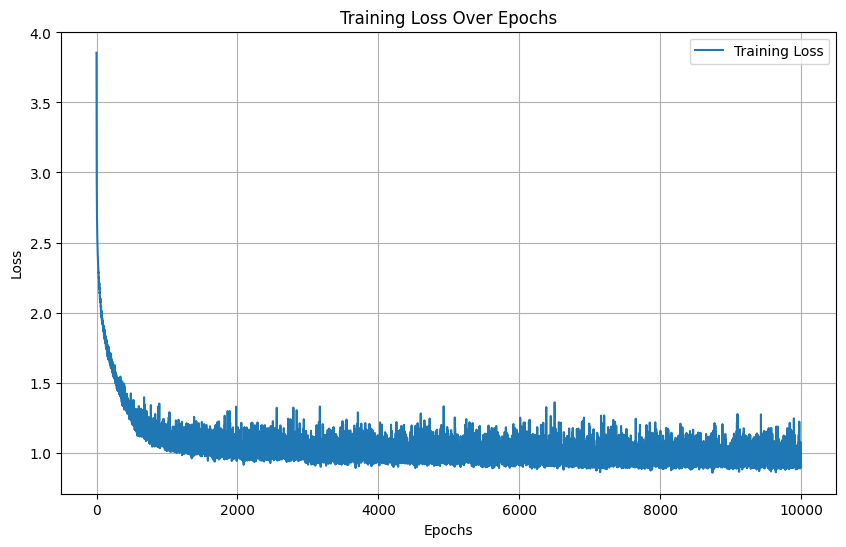

In [33]:
def plot_losses(losses):
    plt.figure(figsize=(10, 6))
    plt.plot(losses, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')
    plt.grid(True)
    plt.legend()
    plt.show()

plot_losses(losses)

В качестве иллюстрации ниже доступен график значений функции потерь, построенный в ходе обучения авторской сети (сам код для ее обучения вам и предстоит написать).

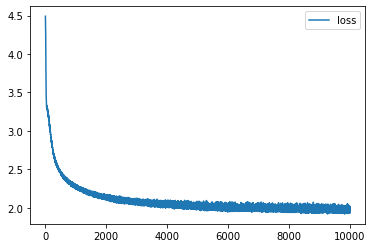

Шаблон функции `generate_sample` также доступен ниже. Вы можете как дозаполнить его, так и написать свою собственную функцию с нуля. Не забывайте, что все примеры в обучающей выборке начинались с токена `<sos>`.

In [34]:
def generate_sample(model, seed_phrase=' мой дядя самых честных правил', max_length=500, temperature=1.0):
    model.eval()
    with torch.no_grad():
        x_sequence = [token_to_idx['<sos>']] + [token_to_idx[char] for char in seed_phrase]
        x_sequence = torch.tensor([x_sequence], dtype=torch.long).to(device)
        hidden = None
        generated_text = seed_phrase

        for _ in range(max_length - len(seed_phrase)):
            logits, hidden = model(x_sequence[:, -1:], hidden)
            logits = logits[:, -1, :] / temperature
            probs = torch.softmax(logits, dim=-1).cpu().numpy()
            next_token = np.random.choice(len(tokens), p=probs.ravel())
            next_char = idx_to_token[next_token]

            generated_text += next_char
            x_sequence = torch.cat([x_sequence, torch.tensor([[next_token]], device=device)], dim=1)

        return generated_text

Пример текста сгенерированного обученной моделью доступен ниже. Не страшно, что в тексте много несуществующих слов. Используемая модель очень проста: это простая классическая RNN.

In [35]:
seed_phrase = ' мой дядя самых честных правил'

# Генерация 10 текстов
generated_phrases = [
    generate_sample(model, seed_phrase=seed_phrase, max_length=500, temperature=0.8)
    for _ in range(10)
]

# Проверяем, что тексты сгенерированы
print("Пример сгенерированного текста:", generated_phrases[0])

Пример сгенерированного текста:  мой дядя самых честных правильда:
доволь и лучший
остановляет привиденье,
всё тронут условин и что не стульян,
но душку поэта сыпать
зарейку вас горованьем
летов наперсе? заню моей,
в тени хранили с лирою нашей
сихорь жердце друзья мои дне,
когда жизнка… искуситель
увидя; ниманы,
не зная, как сердечной,
готов был жертвовать забот,
кресет:
и темный тот же требен.



xxxiii

быть может, друзья! да ничитый,
и надменным светил;
и не блистало, хозяли!» —
«а это душа еще книжку смеж иным,
чтоб прости


In [36]:
# Проверяем, что `generated_phrases` содержит 10 текстов длиной 500 символов
assert len(generated_phrases) == 10, "Должно быть 10 текстов!"
assert all(len(phrase) == 500 for phrase in generated_phrases), "Каждый текст должен быть длиной 500 символов!"

# Проверяем, что токены соответствуют набору символов
assert all([x in set(tokens) for phrase in generated_phrases for x in phrase]), "Неизвестные токены в текстах!"

### Сдача задания
Сгенерируйте десять последовательностей длиной 500, используя строку ' мой дядя самых честных правил'. Температуру для генерации выберите самостоятельно на основании визуального качества генериуремого текста. Не забудьте удалить все технические токены в случае их наличия.

Сгенерированную последовательность сохрание в переменную `generated_phrase` и сдайте сгенерированный ниже файл в контест.

In [37]:
# Генерация текстов с помощью обученной модели
seed_phrase = ' мой дядя самых честных правил'

# Генерируем 10 текстов
generated_phrases = [
    generate_sample(model, seed_phrase=seed_phrase, max_length=500, temperature=0.8)
    for _ in range(10)
]

# Проверяем, что все тексты корректны
for phrase in generated_phrases:
    assert isinstance(phrase, str), "Each phrase must be a string"
    assert len(phrase) == 500, "Each phrase must be exactly 500 characters long"
    assert all([x in tokens for x in phrase]), "Unknown tokens detected in generated phrases!"

print("Все тексты успешно сгенерированы!")

Все тексты успешно сгенерированы!


In [38]:
# do not change the code in the block below
# __________start of block__________

import json
if 'generated_phrases' not in locals():
    raise ValueError("Please, save generated phrases to `generated_phrases` variable")

for phrase in generated_phrases:

    if not isinstance(phrase, str):
        raise ValueError("The generated phrase should be a string")

    if len(phrase) != 500:
        raise ValueError("The `generated_phrase` length should be equal to 500")

    assert all([x in set(tokens) for x in set(list(phrase))]), 'Unknown tokens detected, check your submission!'


submission_dict = {
    'token_to_idx': token_to_idx,
    'generated_phrases': generated_phrases
}

with open('submission_dict.json', 'w') as iofile:
    json.dump(submission_dict, iofile)
print('File saved to `submission_dict.json`')
# __________end of block__________

File saved to `submission_dict.json`


На этом задание завершено. Поздравляем!